In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np

Welcome to JupyROOT 6.30/04


In [2]:
def lin(x, m, q):
    return m * x + q

In [3]:
#Open root file with both shapes and measurements

FILE_PATH = "../Dati/Pi_Day/Run_ch0_Data_3_14_2024_Ascii.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [4]:
#Load data to numpy arrays

baseline = np.array(file["tree"]["base"].array())[: , 0]
charge = np.array(file["tree"]["charge"].array())[: , 0]
amp = np.array(file["tree"]["amp"].array())[: , 0]
pshape = np.array(file["tree"]["pshape"].array())

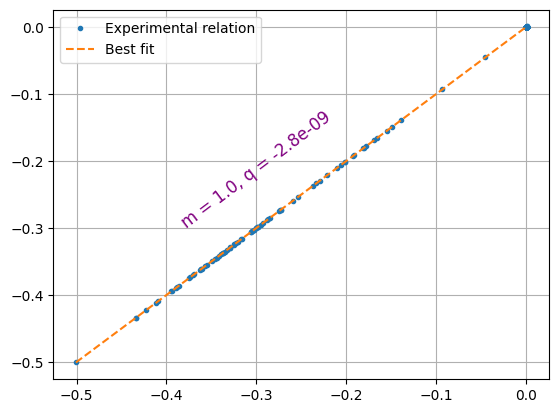

In [18]:
#Evaluate baseline: average of first 16 points

my_baseline = np.zeros(pshape.shape[0])
for i in range(pshape.shape[0]):
    tmp_bs = np.mean(np.round(pshape[i][0][0:16], 6))
    my_baseline[i] = tmp_bs

bsl_fit_res = scp.optimize.curve_fit(lin, baseline, my_baseline)

plt.plot(baseline, my_baseline, ls = "", marker = ".", label = "Experimental relation")
plt.plot([baseline.min(), baseline.max()], [lin(baseline.min(), bsl_fit_res[0][0], bsl_fit_res[0][1]), 
                                            lin(baseline.max(), bsl_fit_res[0][0], bsl_fit_res[0][1])],
        ls = "--", label = "Best fit")

plt.text(-0.3, -0.3, "m = " + str(round(bsl_fit_res[0][0], 2)) + ", q = " + str(round(bsl_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()



[]

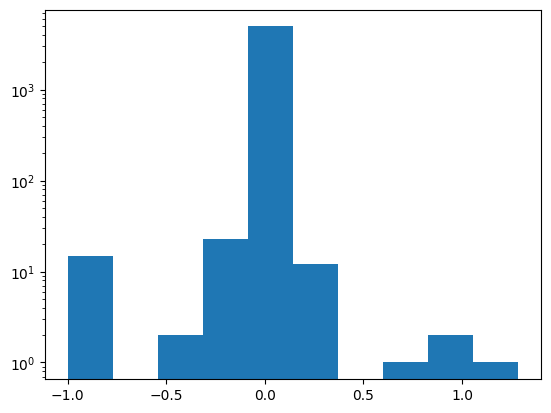

In [19]:
plt.hist((baseline/my_baseline) - 1)
plt.semilogy()

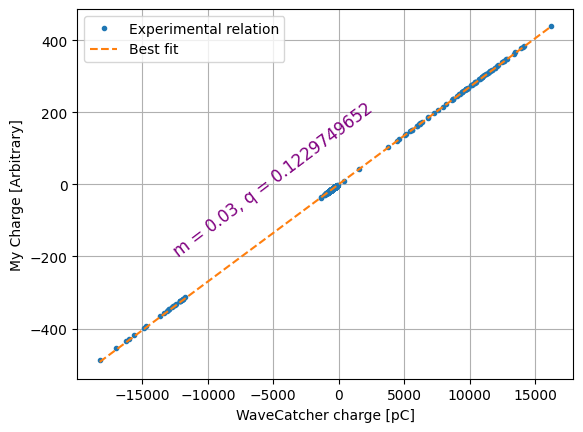

In [36]:
#Evaluate charge

my_charge = np.zeros(pshape.shape[0])
my_charge_2 = np.zeros(pshape.shape[0])


#N.B. 1 div = 1/16th of N Samples (Usually 1024)
int_start = int(pshape.shape[2] / 16 * 0) #Begin evaluating at 0.25 divisions (adjustable)
int_range = int(pshape.shape[2] / 16 * 16) #Keep evaluating for 15.50 divisions (adjistable)

int_start_2 = int(pshape.shape[2] / 16 * 0.25) #Begin evaluating at 0.25 divisions (adjustable)
int_range_2 = int(pshape.shape[2] / 16 * 15.50) #Keep evaluating for 15.50 divisions (adjistable)

X = np.arange(int_range)
Y = np.arange(int_range_2)


for i in range(pshape.shape[0]):
    tmp_ch = trapezoid(pshape[i][0][(int_start):(int_start + int_range)] - my_baseline[i], X)
    my_charge[i] = tmp_ch

    tmp_ch = trapezoid(pshape[i][0][(int_start_2):(int_start_2 + int_range_2)] - my_baseline[i], Y)
    my_charge_2[i] = tmp_ch



chrg_fit_res = scp.optimize.curve_fit(lin, charge, my_charge)


plt.plot(charge, my_charge, ls = "", marker = ".", label = "Experimental relation")

plt.plot([charge.min(), charge.max()], [lin(charge.min(), chrg_fit_res[0][0], chrg_fit_res[0][1]), 
                                            lin(charge.max(), chrg_fit_res[0][0], chrg_fit_res[0][1])],
        ls = "--", label = "Best fit")


plt.text(-5000, -200, "m = " + str(round(chrg_fit_res[0][0], 2)) + ", q = " + str(round(chrg_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)

plt.xlabel("WaveCatcher charge [pC]")
plt.ylabel("My Charge [Arbitrary]")
plt.grid()
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


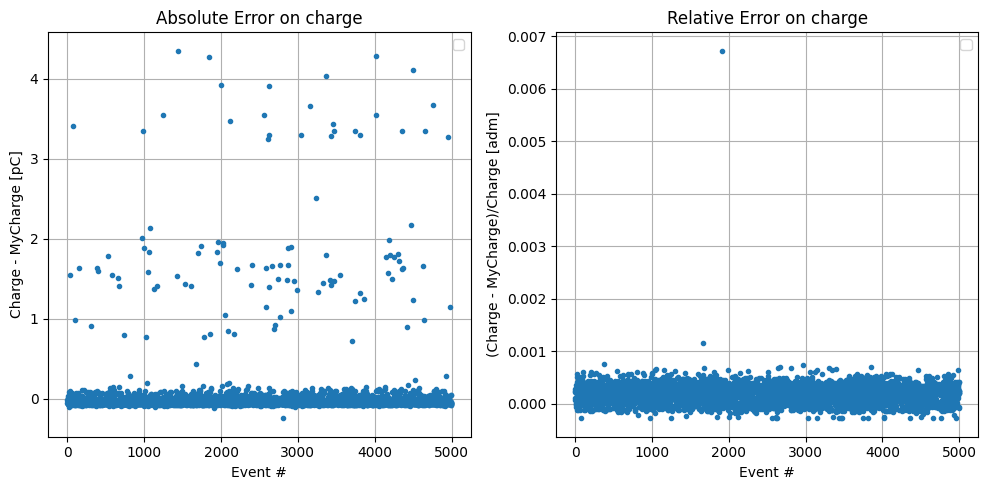

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot data on the first subplot
axs[0].plot(my_charge - lin(charge, chrg_fit_res[0][0], chrg_fit_res[0][1]), ls = "", marker = ".")
axs[0].set_title("Absolute Error on charge")
axs[0].set_xlabel("Event #")
axs[0].set_ylabel('Charge - MyCharge [pC]')
axs[0].legend()
axs[0].grid()

# Plot data on the second subplot
axs[1].plot((my_charge - lin(charge, chrg_fit_res[0][0], chrg_fit_res[0][1])) / charge, ls = "", marker = ".")
axs[1].set_title("Relative Error on charge")
axs[1].set_xlabel("Event #")
axs[1].set_ylabel('(Charge - MyCharge)/Charge [adm]')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

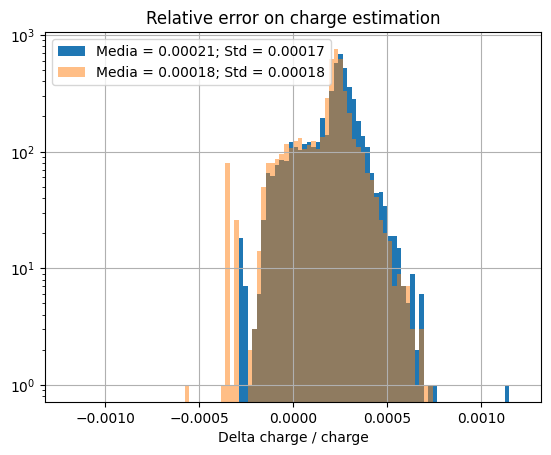

In [43]:
norm_residue = (my_charge - lin(charge, chrg_fit_res[0][0], chrg_fit_res[0][1])) / charge
norm_residue_2 = (my_charge_2 - lin(charge, chrg_fit_res[0][0], chrg_fit_res[0][1])) / charge

media = norm_residue.mean()
std = norm_residue.std()
lbl = "Media = " + str(round(media, 5)) + "; Std = " + str(round(std, 5))
trash = plt.hist(norm_residue, bins = 100, range = (-0.0012, 0.0012) , label = lbl)

media = norm_residue_2.mean()
std = norm_residue_2.std()
lbl = "Media = " + str(round(media, 5)) + "; Std = " + str(round(std, 5))
trash = plt.hist(norm_residue_2, bins = 100, range = (-0.0012, 0.0012) , label = lbl, alpha = 0.5)


plt.semilogy()
plt.grid()
plt.xlabel("Delta charge / charge")
plt.title("Relative error on charge estimation")
plt.legend()

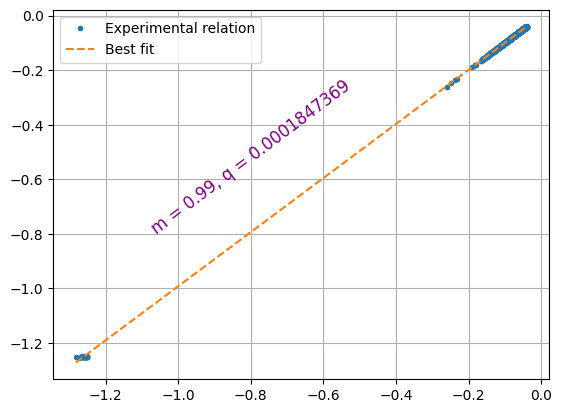

In [26]:
my_amp = np.zeros(pshape.shape[0])
amp_new = np.zeros(pshape.shape[0])
j = 0

for i in range(pshape.shape[0]):
    if(my_charge[i] <=0):
        tmp_amp = pshape[i][0].min()
        my_amp[j] = tmp_amp - my_baseline[i]
        amp_new[j] = amp[i]
        j += 1

amp_new = amp_new[:j]
my_amp = my_amp[0:j]

amp_fit_res = scp.optimize.curve_fit(lin, amp_new, my_amp)

plt.plot(amp_new, my_amp, ls = "", marker = ".", label = "Experimental relation")
plt.plot([amp_new.min(), amp_new.max()], [lin(amp_new.min(), amp_fit_res[0][0], amp_fit_res[0][1]), 
                                            lin(amp_new.max(), amp_fit_res[0][0], amp_fit_res[0][1])],
        ls = "--", label = "Best fit")

plt.text(-0.8, -0.8, "m = " + str(round(amp_fit_res[0][0], 2)) + ", q = " + str(round(amp_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()


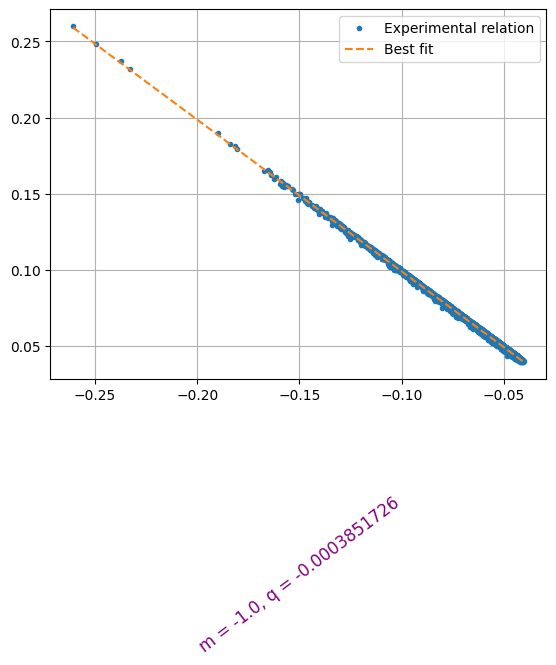

In [27]:
my_amp = np.zeros(pshape.shape[0])
amp_new = np.zeros(pshape.shape[0])
j = 0

for i in range(pshape.shape[0]):
    if(my_charge[i] <=0 and my_charge[i] >-200):
        tmp_amp = np.abs((pshape[i][0] - baseline[i])).max()
        my_amp[j] = tmp_amp - my_baseline[i]
        amp_new[j] = amp[i]
        j += 1

amp_new = amp_new[:j]
my_amp = my_amp[0:j]

amp_fit_res = scp.optimize.curve_fit(lin, amp_new, my_amp)

plt.plot(amp_new, my_amp, ls = "", marker = ".", label = "Experimental relation")
plt.plot([amp_new.min(), amp_new.max()], [lin(amp_new.min(), amp_fit_res[0][0], amp_fit_res[0][1]), 
                                            lin(amp_new.max(), amp_fit_res[0][0], amp_fit_res[0][1])],
        ls = "--", label = "Best fit")

plt.text(-0.15, -0.15, "m = " + str(round(amp_fit_res[0][0], 2)) + ", q = " + str(round(amp_fit_res[0][1], 10)), fontsize=12, color='purple', ha='center', 
        rotation = 37)


plt.legend()
plt.grid()


(array([6.370e+02, 2.362e+03, 9.550e+02, 5.000e+02, 2.560e+02, 1.310e+02,
        3.900e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([-0.0099356 ,  0.00047246,  0.01088053,  0.02128859,  0.03169666,
         0.04210473,  0.05251279,  0.06292086,  0.07332892,  0.08373699,
         0.09414505]),
 <BarContainer object of 10 artists>)

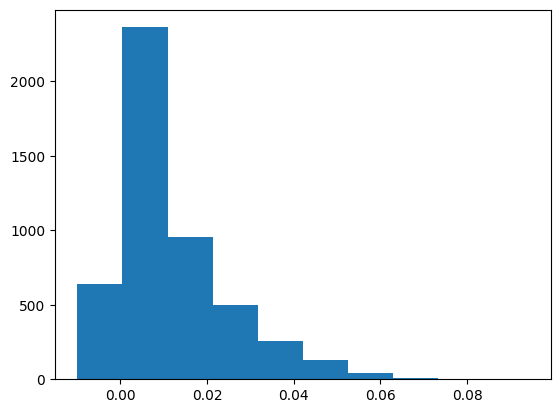

In [28]:
plt.hist((amp_new + my_amp) / amp_new)

In [13]:
def pulse_shape(t, A, t1, t2, t01, t02, base):
    tmp = A * (np.exp(-(t-t01)/t1) - np.exp(-(t-t02)/t2)) + base

    for i in range(len(tmp)):
        if tmp[i] > 0:
            tmp[i] = base
    
    return tmp

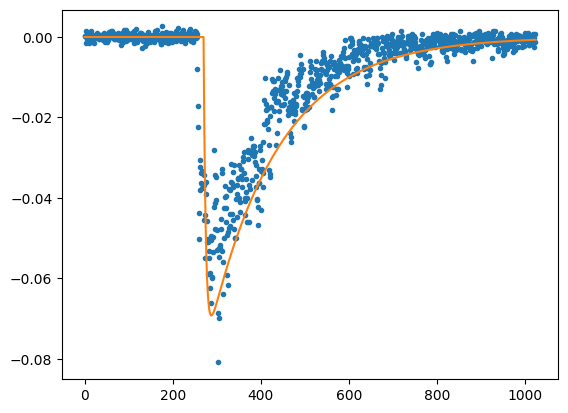

In [14]:

rng = np.arange(0, 1024)

shape_fit_res = scp.optimize.curve_fit(pulse_shape, pshape[0, 0, :], rng, p0 = (-0.08, 380, 5, 270, 270, 0), bounds = ([-1, 0, 0, 0, 0, -0.01], [0, 1000, 1000, 400, 400, 0.0]),
                                       full_output = True, gtol = 1e-15, ftol = 1e-15, xtol = 5e-16)
plt.plot(rng, pshape[0, 0, 0:], ls = "", marker = ".")
plt.plot(np.arange(0, 1024, 0.1), pulse_shape(np.arange(0, 1024, 0.1), shape_fit_res[0][0], shape_fit_res[0][1], shape_fit_res[0][2], 
                                                                       shape_fit_res[0][3], shape_fit_res[0][4], shape_fit_res[0][5]))
#plt.plot(np.arange(0, 1024, 0.1), pulse_shape(np.arange(0, 1024, 0.1), -0.008, 0.15, 0.075, 0.079, 0.4))

In [15]:
shape_fit_res

(array([-8.00000000e-02,  1.58717043e+02,  5.00000000e+00,  2.70000000e+02,
         2.70000000e+02, -1.54320808e-15]),
 array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        , 342.84233792]]),
 {'nfev': 5,
  'fvec': array([-1.54320808e-15, -1.00000000e+00, -2.00000000e+00, ...,
         -1.02100000e+03, -1.02200000e+03, -1.02300000e+03])},
 '`xtol` termination condition is satisfied.',
 3)